<a href="https://colab.research.google.com/github/cumafrank/LoRA_Adversarial_Attack/blob/main/LoRa_Adversarial_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import torch
import torch.nn as nn
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader
import os
from torch.optim import Adam
from torchvision.transforms import Compose, ToTensor, Normalize
from torchvision import datasets


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# **Loading Dataset**

In [3]:
import os
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split

def load_images_and_labels(root_dir, target_size=(224, 224), channels=3):
    images, labels = [], []
    label_dict = {}
    current_label = 0

    for dirname in sorted(os.listdir(root_dir)):
        if dirname not in label_dict:
            label_dict[dirname] = current_label
            current_label += 1

        dirpath = os.path.join(root_dir, dirname)
        class_images = []
        for filename in sorted(os.listdir(dirpath)):
            if filename.endswith('.JPEG'):
                filepath = os.path.join(dirpath, filename)
                try:
                    image = Image.open(filepath)
                    if image.mode != 'RGB':
                        image = image.convert('RGB')  # Convert to RGB
                    image = image.resize(target_size)
                    image = np.array(image, dtype=np.uint8)
                    class_images.append(image)
                    if len(class_images) == 370:
                        break
                except Exception as e:
                    print(f"Error processing {filename}: {e}")

        images.extend(class_images)
        labels.extend([label_dict[dirname]] * len(class_images))

    return np.array(images), np.array(labels)

# Path to your dataset directory
dataset_path = '/content/drive/MyDrive/advance_final/data'

# Load images and labels
images, labels = load_images_and_labels(dataset_path)

# Split the data into train, validation, and test sets
# Note: We are ensuring stratified split to maintain the distribution of classes
X_train, X_temp, y_train, y_temp = train_test_split(images, labels, test_size=350, stratify=labels, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=250, stratify=y_temp, random_state=42)

print(f"Total training examples: {len(X_train)}")
print(f"Total validation examples: {len(X_val)}")
print(f"Total test examples: {len(X_test)}")

Total training examples: 1500
Total validation examples: 100
Total test examples: 250


In [4]:

# Assuming X_train, y_train, X_val, y_val, X_test, y_test are already defined and loaded as per previous steps

def convert_to_dict(images, labels):
    return [{'img': img, 'label': label} for img, label in zip(images, labels)]

# Convert datasets to the required dictionary format
train = convert_to_dict(X_train, y_train)
val = convert_to_dict(X_val, y_val)
test = convert_to_dict(X_test, y_test)


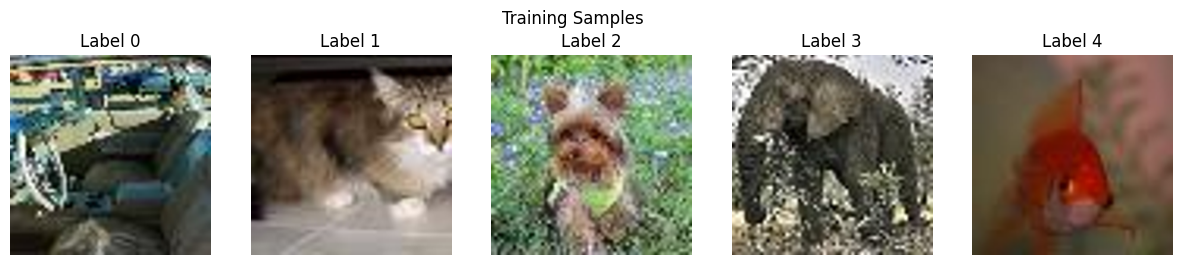

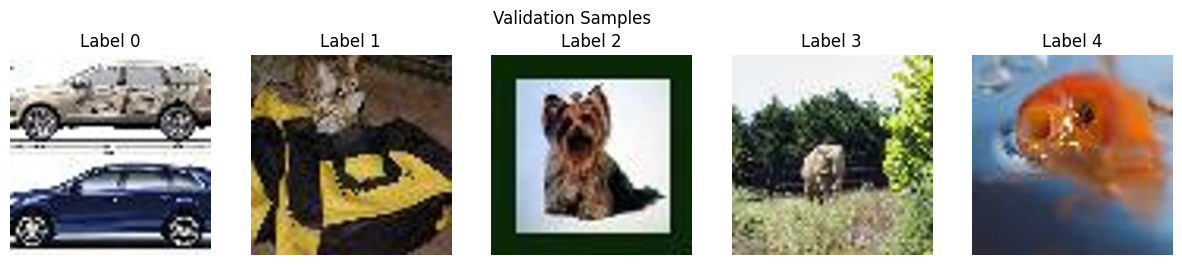

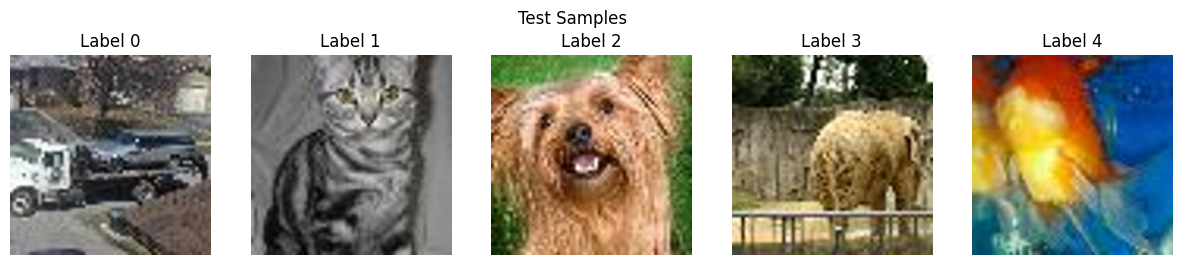

In [5]:
import matplotlib.pyplot as plt
from PIL import Image

def display_samples(dataset, title):
    plt.figure(figsize=(15, 3))
    plt.suptitle(title)
    for i, label in enumerate(range(5)):
        for example in dataset:
            if example['label'] == label:
                image = example['img']
                plt.subplot(1, 5, i + 1)
                plt.imshow(image)
                plt.title(f"Label {label}")
                plt.axis('off')
                break  # Move to the next label after one example is found
    plt.show()

# Display samples from each set
display_samples(train, "Training Samples")
display_samples(val, "Validation Samples")
display_samples(test, "Test Samples")

# **Data Preparation**

In [6]:
from torch.utils.data import Dataset

transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet-50 expects 224x224 images
    transforms.ToTensor()
])

class CustomImageDataset(Dataset):
    def __init__(self, data, transform):
        """
        Args:
            data (list of dicts): List where each dictionary contains 'img' as numpy array and 'label'.
            transform (callable, optional): Optional transform to be applied on a sample.
        """
        self.data = data
        self.transform = transform

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        image_data = self.data[idx]
        # Convert numpy array to PIL Image
        image = Image.fromarray(image_data['img'])
        label = image_data['label']

        if self.transform:
            image = self.transform(image)

        return image, label



# Initialize dataset
train_dataset = CustomImageDataset(train, transform=transform)
val_dataset = CustomImageDataset(val, transform=transform)
test_dataset = CustomImageDataset(test, transform=transform)


# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# **Model Preparation**

## **Architecture Debug**

In [7]:
# Load pre-trained ResNet model
model = models.resnet18(pretrained=True)

/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:00<00:00, 134MB/s]


In [8]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

## **LoRA replaced with fc**

In [9]:
# Define LORA adaptation (fully-connected layer)
class LORALayer(nn.Module):
    def __init__(self, adapted_layer, rank=16):
        super(LORALayer, self).__init__()
        self.adapted_layer = adapted_layer
        # Assuming adaptation applies to a linear layer
        self.A = nn.Parameter(torch.randn(adapted_layer.weight.size(1), rank))
        self.B = nn.Parameter(torch.randn(rank, adapted_layer.weight.size(0)))

    def forward(self, x):
        low_rank_matrix = self.A @ self.B
        adapted_weight = self.adapted_layer.weight + low_rank_matrix.t()  # Ensure correct shape
        return nn.functional.linear(x, adapted_weight, self.adapted_layer.bias)

In [10]:
def adapt_resnet18_with_lora_fc():
    # Load a pre-trained ResNet18 model
    model = models.resnet18(pretrained=True)

    # Freeze the entire model
    for param in model.parameters():
        param.requires_grad = False

    # Apply LORA to the last layer
    #model.fc = LORALayer(model.fc)

    # Unfreeze the newly added LoRA layer
    for param in model.fc.parameters():
        param.requires_grad = True

    # Debug
    # Number of features in the input of the last layer
    num_ftrs = model.fc.in_features
    print('num_ftrs:', num_ftrs)

    # Modify the last layer for 5 classes and apply LORA
    model.fc = nn.Linear(num_ftrs, 5)  # Adjust if your dataset has a different number of classes

    # Apply LORA to the last layer
    model.fc = LORALayer(model.fc)

    return model

In [11]:
model1 = adapt_resnet18_with_lora_fc()

num_ftrs: 512


## **LoRA replaced with Conv1**

In [12]:
class LORAConv(nn.Module):
    def __init__(self, conv_layer, rank=16, alpha=2):
        super(LORAConv, self).__init__()
        self.conv_layer = conv_layer
        self.rank = rank
        self.alpha = alpha

        # Initialize the low-rank matrices A and B
        self.A = nn.Parameter(torch.randn(conv_layer.out_channels, rank))
        self.B = nn.Parameter(torch.randn(rank, conv_layer.in_channels * conv_layer.kernel_size[0] * conv_layer.kernel_size[1]))

    def forward(self, x):
        # Reshape A and B to perform the low-rank approximation
        low_rank_weights = self.A @ self.B
        low_rank_weights = low_rank_weights.view(self.conv_layer.out_channels, self.conv_layer.in_channels, self.conv_layer.kernel_size[0], self.conv_layer.kernel_size[1])

        # Adapt the weights by adding the low-rank approximation scaled by alpha
        adapted_weights = self.conv_layer.weight + self.alpha * low_rank_weights

        # Pass the adapted weights and original bias to the forward convolution
        return self.conv_layer._conv_forward(x, adapted_weights, self.conv_layer.bias)

In [13]:
# Define LORA adaptation (fully-connected layer)
class LORALayer(nn.Module):
    def __init__(self, adapted_layer, rank=16):
        super(LORALayer, self).__init__()
        self.adapted_layer = adapted_layer
        # Assuming adaptation applies to a linear layer
        self.A = nn.Parameter(torch.randn(adapted_layer.weight.size(1), rank))
        self.B = nn.Parameter(torch.randn(rank, adapted_layer.weight.size(0)))

    def forward(self, x):
        low_rank_matrix = self.A @ self.B
        adapted_weight = self.adapted_layer.weight + low_rank_matrix.t()  # Ensure correct shape
        return nn.functional.linear(x, adapted_weight, self.adapted_layer.bias)

In [14]:
def adapt_resnet18_with_lora_conv1():
    # Load a pre-trained ResNet18 model
    model = models.resnet18(pretrained=True)

    # Freeze the entire model
    for param in model.parameters():
        param.requires_grad = False

    # Replace the first convolutional layer with a LoRA adapted layer
    first_conv_layer = model.conv1
    first_fc_layer = model.fc
    model.conv1 = LORAConv(first_conv_layer, rank=16, alpha=2)
    model.fc = LORALayer(first_fc_layer)


    # Unfreeze the newly added LoRA layer
    for param in model.conv1.parameters():
        param.requires_grad = True
    # Unfreeze the newly added LoRA layer
    for param in model.fc.parameters():
        param.requires_grad = True

    return model

In [15]:
model2 = adapt_resnet18_with_lora_conv1()

## **LoRA as additive adjustment - fc**

In [16]:
class LoRALayer(nn.Module):
    def __init__(self, in_dim, out_dim, rank, alpha):
        super(LoRALayer, self).__init__()
        std_dev = 1 / torch.sqrt(torch.tensor(rank).float())
        self.A = nn.Parameter(torch.randn(in_dim, rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(rank, out_dim))
        self.alpha = alpha

    def forward(self, x):
        low_rank_modification = self.alpha * (x @ self.A @ self.B)
        return low_rank_modification

class LinearWithLoRA(nn.Module):
    def __init__(self, linear, rank, alpha):
        super(LinearWithLoRA, self).__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        original_out = self.linear(x)
        lora_out = self.lora(x)
        return original_out + lora_out

class LinearWithLoRAMerged(nn.Module):
    def __init__(self, linear, rank, alpha):
        super(LinearWithLoRAMerged, self).__init__()
        self.linear = linear
        self.lora = LoRALayer(
            linear.in_features, linear.out_features, rank, alpha
        )

    def forward(self, x):
        # Precompute LoRA-modified weights
        lora_modification = self.lora.A @ self.lora.B
        combined_weight = self.linear.weight + self.lora.alpha * lora_modification.T
        return F.linear(x, combined_weight, self.linear.bias)

In [17]:
class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes, rank, alpha):
        super(ModifiedResNet18, self).__init__()
        # Load a pre-trained ResNet18 model
        original_model = models.resnet18(pretrained=True)

        # Freeze all layers first to prevent updating during training
        for param in original_model.parameters():
            param.requires_grad = False

        # Replace the fully connected layer with a LoRA-enhanced layer
        self.features = nn.Sequential(*list(original_model.children())[:-1])  # retain all layers except the last one
        self.fc = LinearWithLoRA(original_model.fc, rank, alpha)

        # Adjust the output features of the last fully connected layer
        self.fc.linear = nn.Linear(in_features=original_model.fc.in_features, out_features=num_classes, bias=True)

    def forward(self, x):
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        x = self.fc(x)
        return x

In [18]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3 = ModifiedResNet18(num_classes=1000, rank=32, alpha=2).to(device)

## **LoRA as additive adjustment - Conv1 + fc**


In [19]:
import torch
import torch.nn as nn
from torchvision import models
import torch.nn.functional as F


class LoRALayer(nn.Module):
    def __init__(self, conv_layer, rank, alpha):
        super(LoRALayer, self).__init__()
        self.alpha = alpha
        self.rank = rank
        self.conv_layer = conv_layer

        # Initialize the low-rank matrices A and B
        # A modifies the output channels, B modifies the input channels multiplied by the kernel size
        self.A = nn.Parameter(torch.randn(self.conv_layer.out_channels, self.rank))
        self.B = nn.Parameter(torch.randn(self.rank, self.conv_layer.in_channels * self.conv_layer.kernel_size[0] * self.conv_layer.kernel_size[1]))

    def forward(self, x):
        # Calculate the low-rank modification of the weights
        low_rank_weights = self.alpha * (self.A @ self.B).view(self.conv_layer.out_channels, self.conv_layer.in_channels, *self.conv_layer.kernel_size)

        # Apply this modification to the original weights
        adapted_weights = self.conv_layer.weight + low_rank_weights

        # Perform the convolution with adapted weights
        return F.conv2d(x, adapted_weights, self.conv_layer.bias, stride=self.conv_layer.stride, padding=self.conv_layer.padding)

class ModifiedConv2d(nn.Module):
    def __init__(self, conv_layer, rank, alpha):
        super(ModifiedConv2d, self).__init__()
        self.lora = LoRALayer(conv_layer, rank, alpha)

    def forward(self, x):
        return self.lora(x)


class ModifiedResNet18(nn.Module):
    def __init__(self, num_classes, rank, alpha):
        super(ModifiedResNet18, self).__init__()
        original_model = models.resnet18(pretrained=True)

        # Replace the first conv layer with the modified one
        self.conv1 = ModifiedConv2d(original_model.conv1, rank, alpha)
        self.features = nn.Sequential(*list(original_model.children())[1:-1])
        self.fc = original_model.fc

    def forward(self, x):
        x = self.conv1(x)
        x = self.features(x)
        x = x.view(x.size(0), -1)  # Flatten the features
        x = self.fc(x)
        return x


# Assuming `model` is an instance of `ModifiedResNet18` and `inputs` is a batch from your dataloader
for inputs, labels in train_loader:
        inputs = inputs.to(device)
        labels = labels.to(device)
        break
model4 = ModifiedResNet18(num_classes=1000, rank=32, alpha=2).to(device)
try:
    with torch.no_grad():
        output = model4(torch.randn(1, 3, 224, 224).to(device))  # Example input
    print("Output shape:", output.shape)
except Exception as e:
    print("Error during forward pass:", e)

Output shape: torch.Size([1, 1000])


## **Base model**

In [20]:
model_base = models.resnet18(pretrained=True)  # Use pretrained=False for training from scratch
model_base.fc = nn.Linear(model_base.fc.in_features, 1000)  # Adjusting the final layer for 1000 classes of ImageNet
model_base = model_base.to(device)


# **Model Training**

In [ ]:
from torch.optim import lr_scheduler
import time


num_epochs = 20

# Check if CUDA (GPU support) is available and use it; otherwise, fall back to CPU
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Move the model to the selected device
model = model.to(device)


# Track losses and accuracies
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

# Implement a learning rate scheduler
scheduler = lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

best_val_accuracy = 0.0
best_model_wts = model.state_dict()

for epoch in range(num_epochs):
    start_time = time.time()
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    scheduler.step()  # Adjust the learning rate based on the scheduler
    train_accuracy = 100 * correct / total
    train_losses.append(running_loss / len(train_loader))
    train_accuracies.append(train_accuracy)

    # Validation phase
    model.eval()
    val_running_loss = 0.0
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    val_accuracy = 100 * correct / total
    val_losses.append(val_running_loss / len(val_loader))
    val_accuracies.append(val_accuracy)

    epoch_duration = time.time() - start_time

    # Save the model if validation accuracy improves
    if val_accuracy > best_val_accuracy:
        best_val_accuracy = val_accuracy
        best_model_wts = model.state_dict()

    print(f'Epoch {epoch+1}, Train Loss: {running_loss / len(train_loader)}, Train Accuracy: {train_accuracy}%, Val Loss: {val_running_loss / len(val_loader)}, Val Accuracy: {val_accuracy}%, Time: {epoch_duration:.2f}s')

Epoch 1, Train Loss: 12.068704194210945, Train Accuracy: 73.26666666666667%, Val Loss: 12.162287712097168, Val Accuracy: 74.0%, Time: 156.36s
Epoch 2, Train Loss: 10.551440325189144, Train Accuracy: 75.06666666666666%, Val Loss: 10.674006342887878, Val Accuracy: 74.0%, Time: 154.59s
Epoch 3, Train Loss: 9.076293511593596, Train Accuracy: 78.26666666666667%, Val Loss: 8.860548615455627, Val Accuracy: 79.0%, Time: 153.71s
Epoch 4, Train Loss: 8.008334999388836, Train Accuracy: 81.46666666666667%, Val Loss: 6.373351886868477, Val Accuracy: 82.0%, Time: 154.05s
Epoch 5, Train Loss: 7.241422565693551, Train Accuracy: 80.66666666666667%, Val Loss: 6.308713734149933, Val Accuracy: 82.0%, Time: 152.72s
Epoch 6, Train Loss: 6.665670225573311, Train Accuracy: 81.93333333333334%, Val Loss: 5.953433014452457, Val Accuracy: 84.0%, Time: 154.26s
Epoch 7, Train Loss: 5.868663905465857, Train Accuracy: 84.13333333333334%, Val Loss: 4.910741806030018, Val Accuracy: 83.0%, Time: 152.53s
Epoch 8, Train L

In [ ]:
# Load the best model weights
model.load_state_dict(best_model_wts)

# Save the best model to disk
torch.save(model.state_dict(), '/content/drive/MyDrive/advance_final/best_model2.pth')


In [ ]:
model_path = '/content/drive/MyDrive/advance_final/best_model2.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load(model_path, map_location=device))
model.to(device)



ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

# **Loading model check point**

In [21]:
model_base_path = '/content/drive/MyDrive/advance_final/databest_resnet18.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_base.load_state_dict(torch.load(model_base_path, map_location=device))
#model_base.to(device)

<All keys matched successfully>

In [22]:
model4_path = '/content/drive/MyDrive/advance_final/databest_model_additive_conv1_fc.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model4.load_state_dict(torch.load(model4_path, map_location=device))
#model_base.to(device)

<All keys matched successfully>

In [23]:
model3_path = '/content/drive/MyDrive/advance_final/databest_model_additive_fc.pth'
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model3.load_state_dict(torch.load(model3_path, map_location=device))
#model_base.to(device)

<All keys matched successfully>

# **Test the result**

## **Test with basline**

Test Accuracy: 93.6%


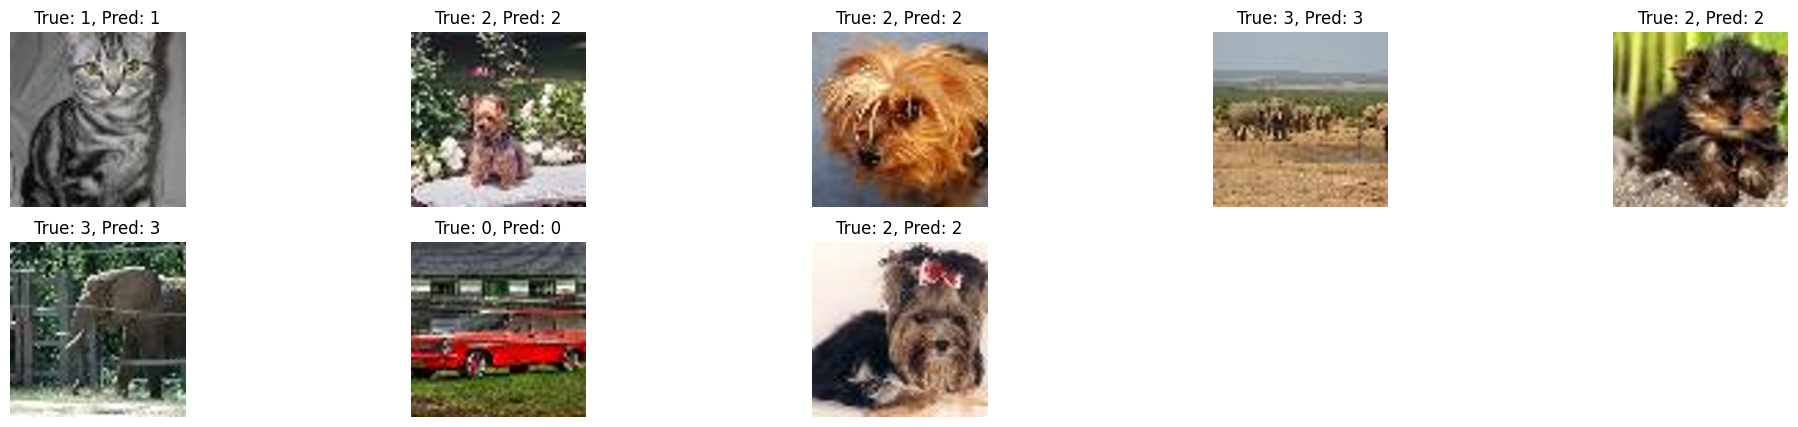

In [24]:

# Test phase (after training is complete and best model is loaded)
model_base.eval()
correct = 0
total = 0
fig = plt.figure(figsize=(25, 5))  # Define figure size

# We will visualize the first 10 images of the test set
for i, (images, labels) in enumerate(test_loader, start=1):
    if i > 10:  # Stop after visualizing 10 images
        break
    images, labels = images.to(device), labels.to(device)
    outputs = model_base(images)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    ax = fig.add_subplot(2, 5, i)  # Plotting 10 images in 2 rows and 5 columns
    ax.imshow(images[0].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title(f"True: {labels[0].item()}, Pred: {predicted[0].item()}")
    ax.axis('off')


test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy}%')
plt.show()

## **Test with LoRA as additive adjustment - fc**

Test Accuracy: 94.8%


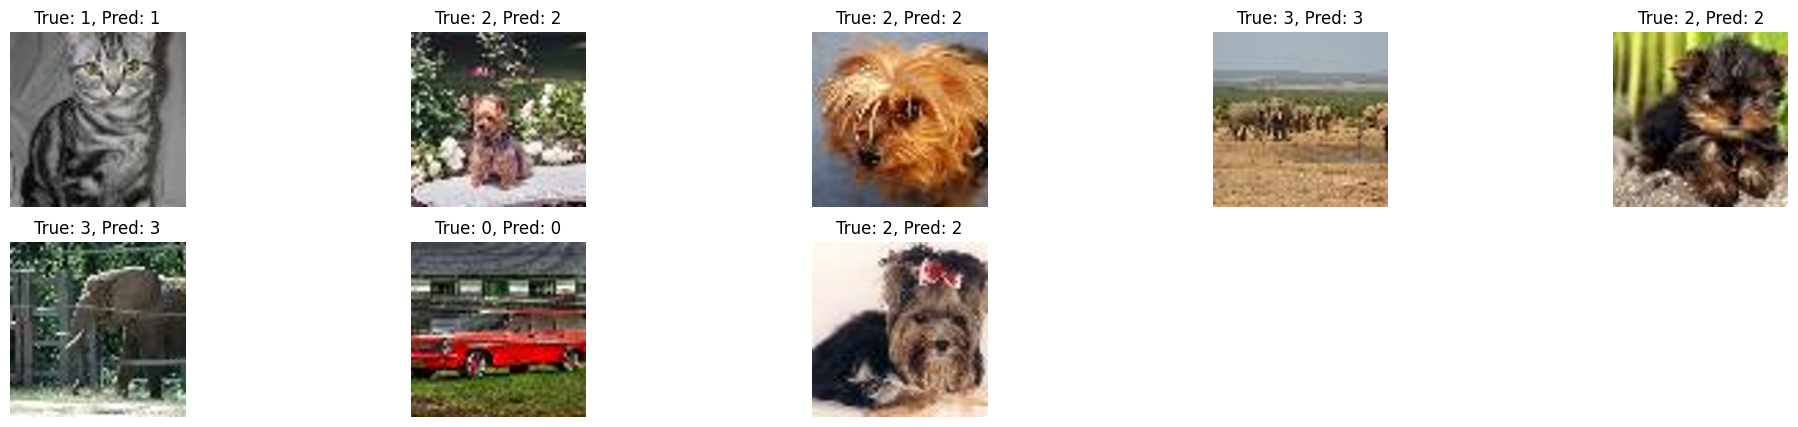

In [25]:

# Test phase (after training is complete and best model is loaded)
model3.eval()
correct = 0
total = 0
fig = plt.figure(figsize=(25, 5))  # Define figure size

# We will visualize the first 10 images of the test set
for i, (images, labels) in enumerate(test_loader, start=1):
    if i > 10:  # Stop after visualizing 10 images
        break
    images, labels = images.to(device), labels.to(device)
    outputs = model3(images)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    ax = fig.add_subplot(2, 5, i)  # Plotting 10 images in 2 rows and 5 columns
    ax.imshow(images[0].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title(f"True: {labels[0].item()}, Pred: {predicted[0].item()}")
    ax.axis('off')


test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy}%')
plt.show()

## **Test with LoRA as additive adjustment - Conv1 + fc**

Test Accuracy: 90.8%


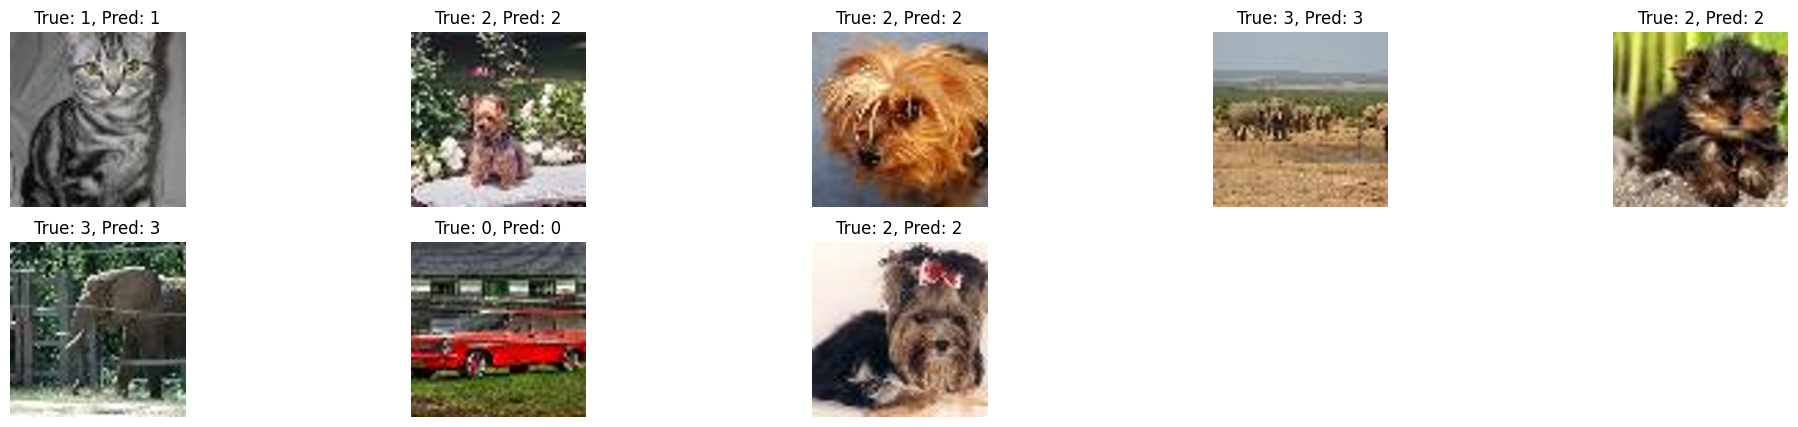

In [26]:

# Test phase (after training is complete and best model is loaded)
model4.eval()
correct = 0
total = 0
fig = plt.figure(figsize=(25, 5))  # Define figure size

# We will visualize the first 10 images of the test set
for i, (images, labels) in enumerate(test_loader, start=1):
    if i > 10:  # Stop after visualizing 10 images
        break
    images, labels = images.to(device), labels.to(device)
    outputs = model4(images)
    _, predicted = torch.max(outputs, 1)

    total += labels.size(0)
    correct += (predicted == labels).sum().item()

    ax = fig.add_subplot(2, 5, i)  # Plotting 10 images in 2 rows and 5 columns
    ax.imshow(images[0].cpu().numpy().transpose((1, 2, 0)))
    ax.set_title(f"True: {labels[0].item()}, Pred: {predicted[0].item()}")
    ax.axis('off')


test_accuracy = 100 * correct / total
print(f'Test Accuracy: {test_accuracy}%')
plt.show()

# **Adversarial Attack**

## **Evaulate**

In [30]:
def unnormalize(img, mean = np.array(norm_mean), std = np.array(norm_std)):
  '''
   unnormalize the image that has been normalized with mean and std
  '''
  inverse_mean = - mean/std
  inverse_std = 1/std
  img = transforms.Normalize(mean=-mean/std, std=1/std)(img)
  return img

def normalize(img, mean = np.array(norm_mean), std = np.array(norm_std)):
  return transforms.Normalize(mean = norm_mean, std = norm_std)(img)

In [31]:
test_loader = DataLoader(test_dataset, shuffle=False)

In [32]:
import torch
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import models

def fgsm_attack(model, device, data, labels, epsilon, norm_mean, norm_std):

    data.requires_grad = True
    outputs = model(data)
    model.zero_grad()
    loss = F.cross_entropy(outputs, labels)
    loss.backward()
    data_grad = data.grad.data
    perturbed_data = unnormalize(data)
    perturbed_data = data + epsilon * data_grad.sign()
    perturbed_data = torch.clamp(perturbed_data, 0, 1)
    perturbed_data = normalize(perturbed_data).detach()
    return perturbed_data.float()

def pgd_attack(model, device, data, labels, epsilon, alpha, num_iter, norm_mean, norm_std):


    mean = torch.tensor(norm_mean).view(1, -1, 1, 1).to(device)
    std = torch.tensor(norm_std).view(1, -1, 1, 1).to(device)

    # Clone the data to avoid affecting original data
    original_data = data.clone().detach()

    # Denormalize the data
    data = data * std + mean

    # Initialize perturbed data
    perturbed_data = data.clone().detach()
    perturbed_data.requires_grad = True

    for _ in range(num_iter):
        outputs = model((perturbed_data - mean) / std).to(device)  # Normalize before feeding into the model
        loss = F.cross_entropy(outputs, labels)
        model.zero_grad()
        loss.backward()

        # Apply the perturbation using the sign of the gradients
        perturbed_data = perturbed_data + alpha * perturbed_data.grad.sign()

        # Ensure the perturbations are clipped to the epsilon neighborhood and within valid image range
        perturbed_data = torch.max(torch.min(perturbed_data, data + epsilon), data - epsilon)
        perturbed_data = torch.clamp(perturbed_data, 0, 1)

        perturbed_data = perturbed_data.detach().requires_grad_(True)

    # Normalize the data before returning
    perturbed_data = (perturbed_data - mean) / std
    return perturbed_data.detach()




def evaluate_attacks(model, device, test_loader, epsilon_fgsm, alpha_pgd, epsilon_pgd, num_iter_pgd,norm_mean,norm_std):
    """Evaluate FGSM and PGD attacks based on correctly predicted examples."""
    model.eval()
    correct_before_attack = 0
    success_count_fgsm = 0
    success_count_pgd = 0
    total_predictions = 0
    model_confidence_fgsm = []
    model_confidence_pgd = []
    model_confidence = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)

        # Evaluate the original model's accuracy on unperturbed data
        with torch.no_grad():
            original_outputs = model(data)
            _, original_preds = original_outputs.max(1)
            correct_before_attack += (original_preds == target).sum().item()

        # Apply attacks only to examples that were originally predicted correctly
        correctly_predicted_mask = (original_preds == target)
        correctly_predicted_data = data[correctly_predicted_mask]
        correctly_predicted_labels = target[correctly_predicted_mask]
        probabilities = F.softmax(original_outputs, dim=1)
        model_confidence.extend(probabilities.max(dim=1)[0].tolist())

        if len(correctly_predicted_data) > 0:
            perturbed_data_fgsm = fgsm_attack(model, device, correctly_predicted_data, correctly_predicted_labels, epsilon_fgsm, norm_mean, norm_std)
            perturbed_data_pgd = pgd_attack(model, device, correctly_predicted_data, correctly_predicted_labels, epsilon_pgd, alpha_pgd, num_iter_pgd, norm_mean, norm_std)

            with torch.no_grad():
                output_fgsm = model(perturbed_data_fgsm)
                output_pgd = model(perturbed_data_pgd)
                probabilities_fgsm = F.softmax(output_fgsm, dim=1)
                probabilities_pgd = F.softmax(output_pgd, dim=1)
                #print(output_fgsm)

                _, preds_fgsm = output_fgsm.max(1)
                _, preds_pgd = output_pgd.max(1)

                success_count_fgsm += (preds_fgsm != correctly_predicted_labels).sum().item()
                success_count_pgd += (preds_pgd != correctly_predicted_labels).sum().item()

                # Model confidence on perturbed data
                model_confidence_fgsm.extend(probabilities_fgsm.max(dim=1)[0].tolist())
                model_confidence_pgd.extend(probabilities_pgd.max(dim=1)[0].tolist())
                #print(model_confidence_fgsm)

    #print(model_confidence_fgsm)
    attack_success_rate_fgsm = success_count_fgsm / correct_before_attack if correct_before_attack > 0 else 0
    attack_success_rate_pgd = success_count_pgd / correct_before_attack if correct_before_attack > 0 else 0
    average_confidence_fgsm = sum(model_confidence_fgsm) / len(model_confidence_fgsm) if model_confidence_fgsm else 0
    average_confidence_pgd = sum(model_confidence_pgd) / len(model_confidence_pgd) if model_confidence_pgd else 0
    average_confidence = sum(model_confidence) / len(model_confidence) if model_confidence else 0

    #print('success_cnt : ',correct_before_attack)
    #print(success_count_pgd)
    #print('test: ',success_count_pgd)

    print(f"Correct Predictions Before Attack: {correct_before_attack}, Average Confidence: {average_confidence:.3f}")
    print(f"FGSM Attack Success Rate: {attack_success_rate_fgsm:.2f}, Average Confidence: {average_confidence_fgsm:.2f}")
    print(f"PGD Attack Success Rate: {attack_success_rate_pgd:.2f}, Average Confidence: {average_confidence_pgd:.3f}")

    return attack_success_rate_fgsm, average_confidence_fgsm, attack_success_rate_pgd, average_confidence_pgd
    #return attack_success_rate_fgsm, average_confidence_fgsm

# Parameters
epsilon_fgsm = 0.03  # Example value
alpha_pgd = 0.01    # Step size for PGD
epsilon_pgd = 0.03  # Perturbation limit for PGD
num_iter_pgd = 5   # Number of iterations for PGD
# Parameters for normalization based on the model's training (example values)
norm_mean = [0.485, 0.456, 0.406]
norm_std = [0.229, 0.224, 0.225]

# Assuming test_loader is defined and model_path is set
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# test_loader = DataLoader(...)

#evaluate_attacks(model, device, test_loader, epsilon_fgsm, alpha_pgd, epsilon_pgd, num_iter_pgd,norm_mean,norm_std)

In [33]:
evaluate_attacks(model3, device, test_loader, epsilon_fgsm, alpha_pgd, epsilon_pgd, num_iter_pgd,norm_mean,norm_std)

Correct Predictions Before Attack: 237, Average Confidence: 0.949
FGSM Attack Success Rate: 0.78, Average Confidence: 0.73
PGD Attack Success Rate: 1.00, Average Confidence: 0.987


(0.7805907172995781, 0.7250188638137866, 1.0, 0.9872646915258737)

In [34]:
evaluate_attacks(model4, device, test_loader, epsilon_fgsm, alpha_pgd, epsilon_pgd, num_iter_pgd,norm_mean,norm_std)

Correct Predictions Before Attack: 227, Average Confidence: 0.965
FGSM Attack Success Rate: 0.73, Average Confidence: 0.93
PGD Attack Success Rate: 1.00, Average Confidence: 1.000


(0.7312775330396476, 0.9275883558300624, 1.0, 0.9999897797727375)

In [35]:
evaluate_attacks(model_base, device, test_loader, epsilon_fgsm, alpha_pgd, epsilon_pgd, num_iter_pgd,norm_mean,norm_std)

Correct Predictions Before Attack: 234, Average Confidence: 0.956
FGSM Attack Success Rate: 0.77, Average Confidence: 0.99
PGD Attack Success Rate: 1.00, Average Confidence: 0.999


(0.7735042735042735, 0.9883432630290333, 1.0, 0.9988966255615919)